#1. Import Libraries


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Import dataset from Google Drive

In [56]:
df =pd.read_excel("/content/drive/MyDrive/MASA_Hack/Travel_Ins.xlsx")
df

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,M,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,F,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,M,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,M,63


In [57]:
#Rename the column to remove spaces
df.rename(columns={ 'Agency Type':'Type', 'Distribution Channel':'Channel', 'Product Name':'Product','Net Sales':'Net_Sales', 'Commision (in value)':'Commision'},inplace=True)

#3. EDA (Simple one, more details in PowerBi)

##Separate the column into numerical and categorical

In [13]:
##Separate the column into numerical and categorical 
numerical=['Duration','Net_Sales','Commision','Age']
categorical=['Agency','Type','Channel','Product','Claim','Destination','Gender']
df=df[numerical+categorical]

##Density and distribution plot for Numerical column

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


---------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


---------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


---------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


---------------------------------------------------------------------------


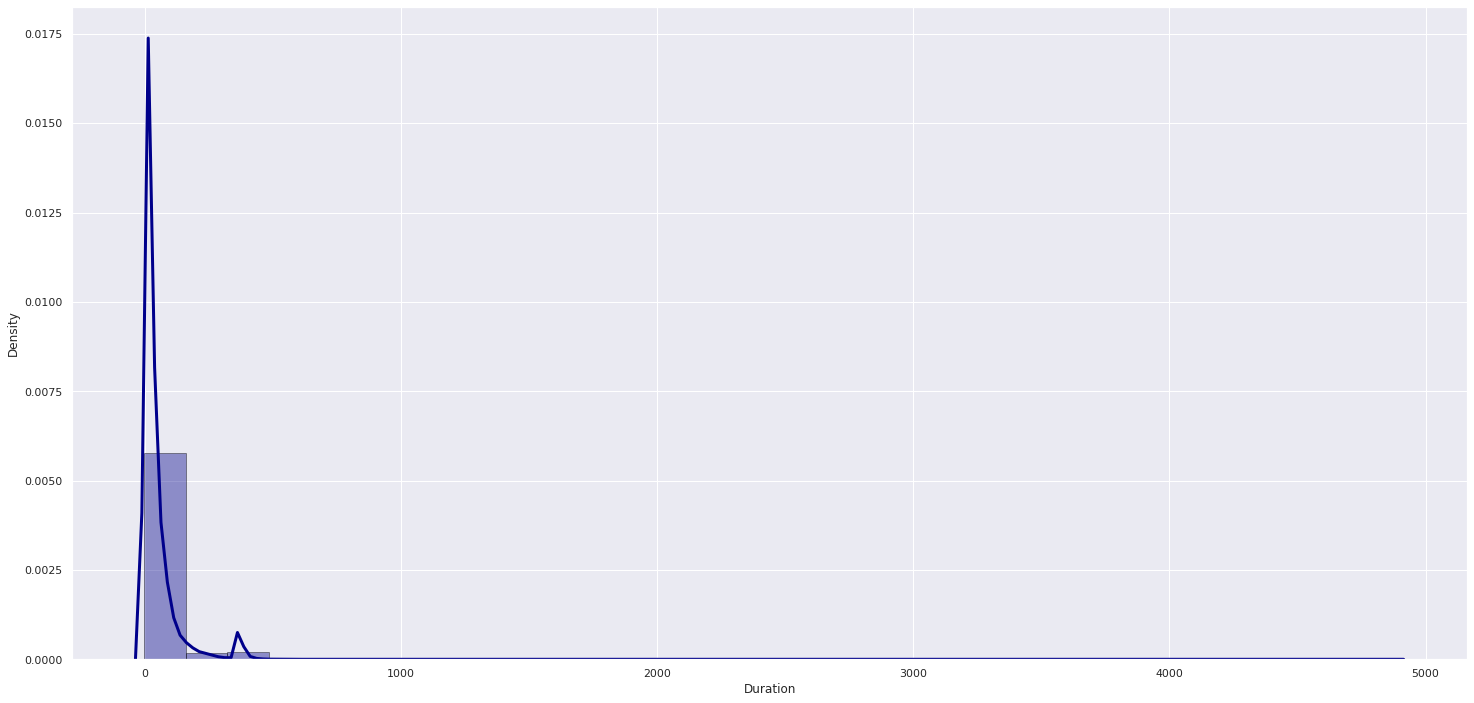

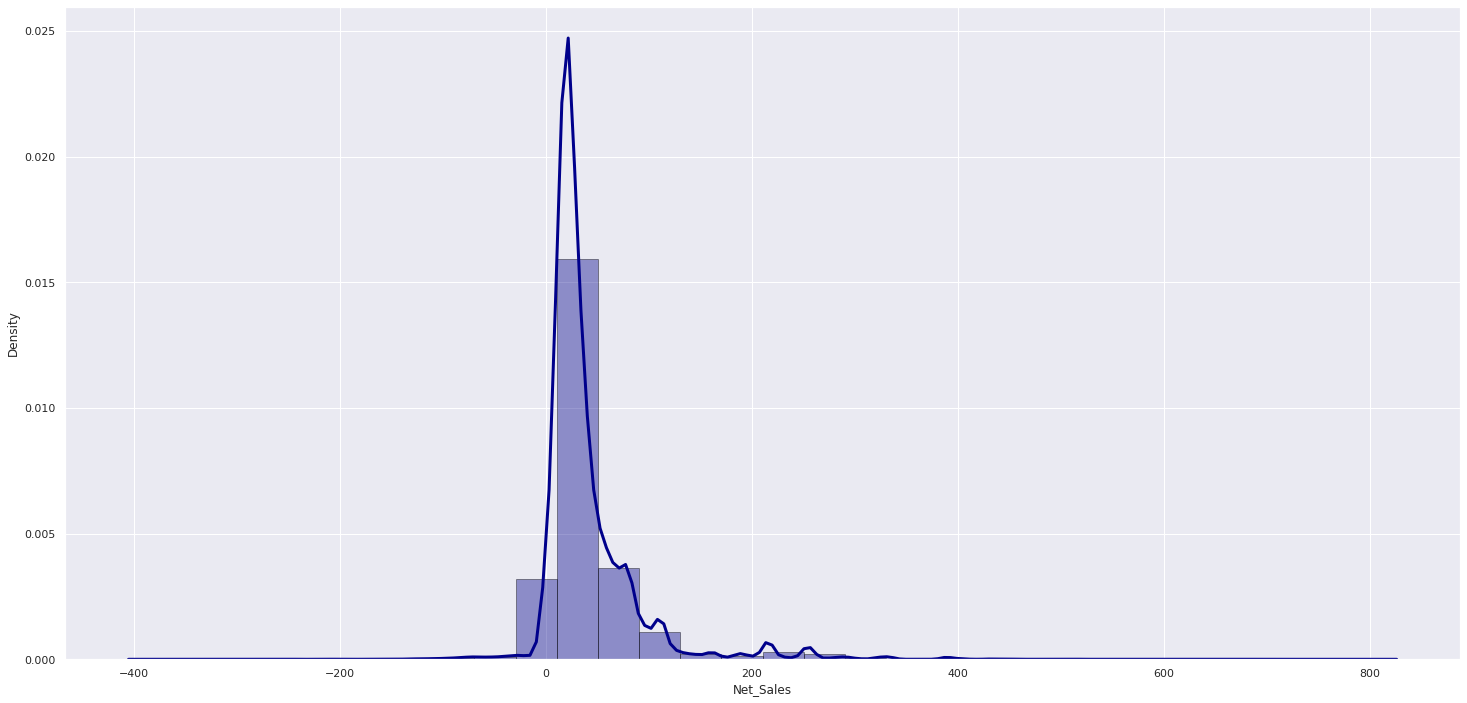

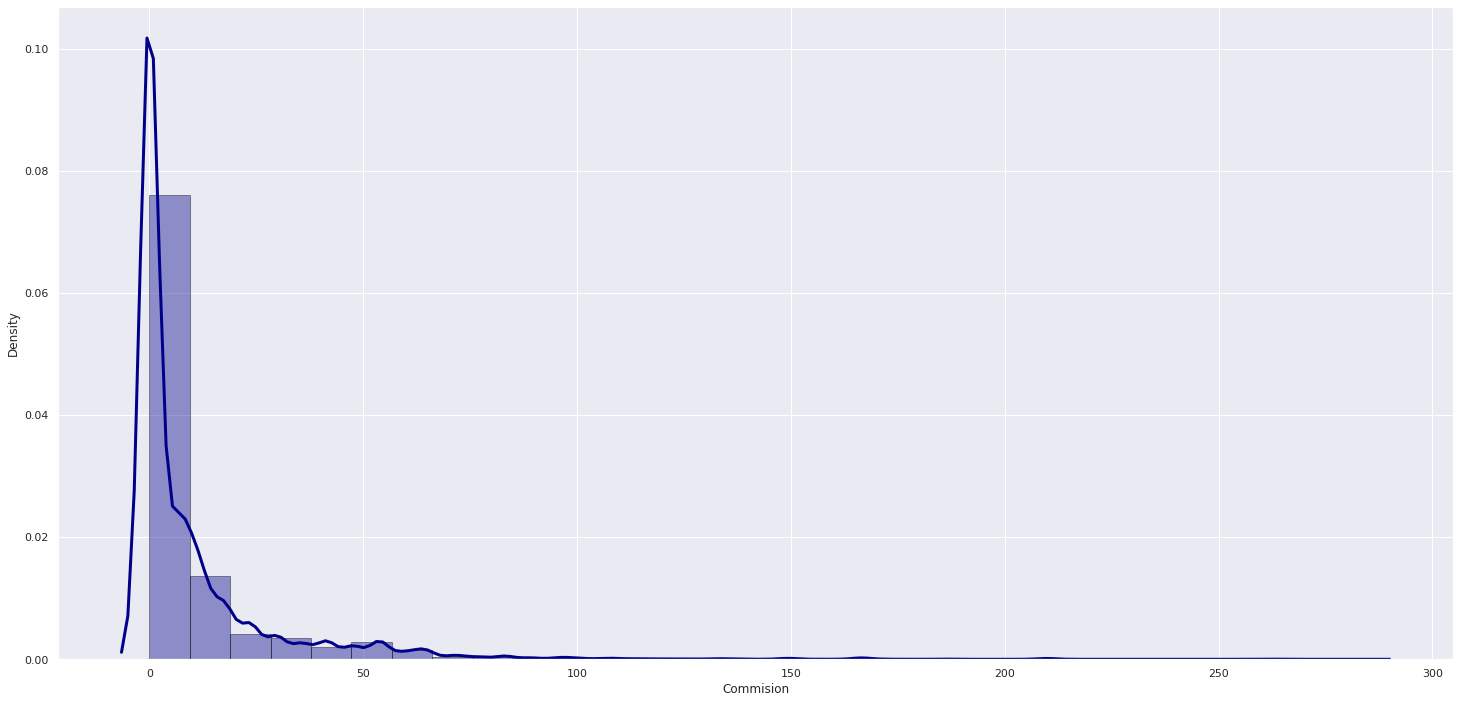

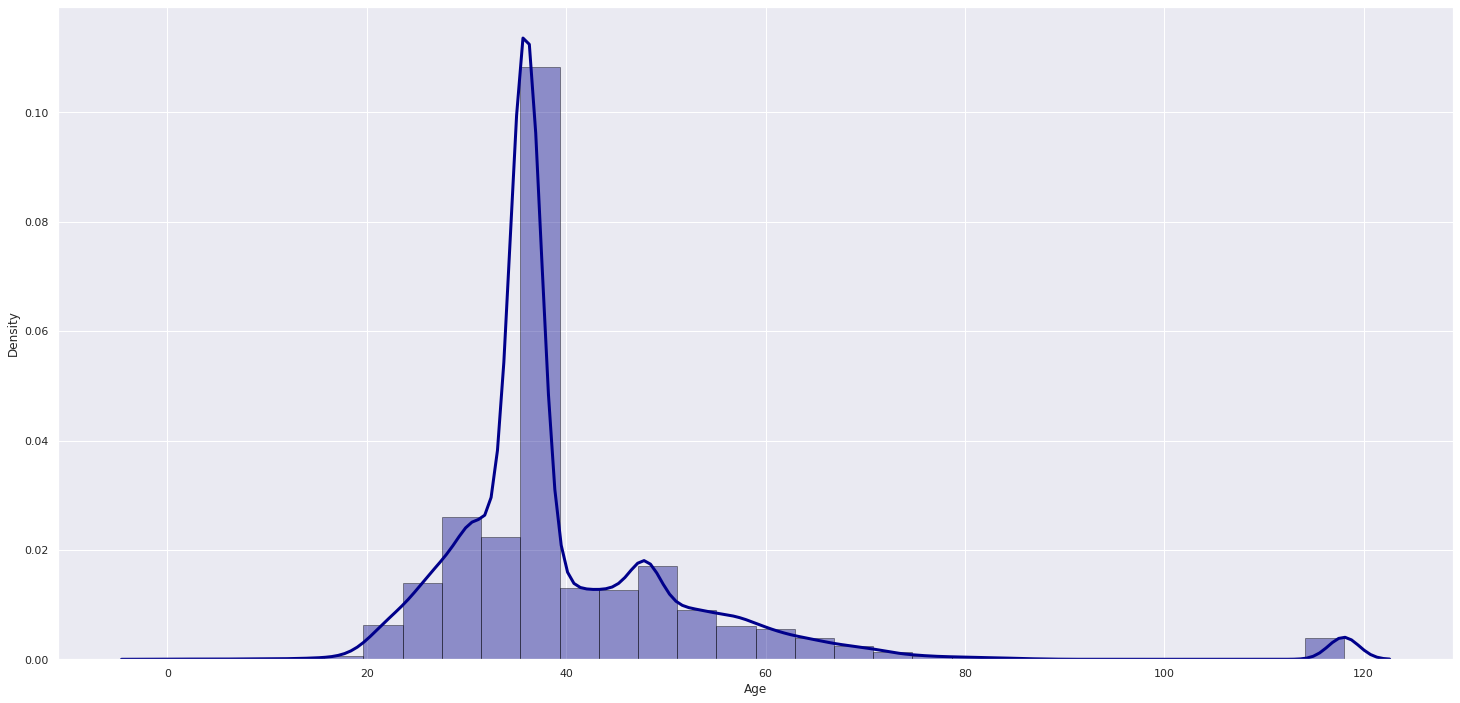

In [29]:
sns.set(rc={'figure.figsize':(25,12)})
for i in numerical:
    plt.figure()
    sns.distplot(df[i], hist=True, kde=True, 
                bins=30, color = 'darkblue', 
                hist_kws={'edgecolor':'black'},
                kde_kws={'linewidth': 3})
  

##Pie Chart for categorical column

In [42]:
title=['Top 5 Agencies','Type of Agencies','Distribution Channel Used','Top 5 Products','Claim Success Rate','Top 5 Destination','Gender Comparison']
fig = plt.figure(figsize = (20, 10))
for i in range(len(categorical)):
    df_= df.groupby(by=[categorical[i]]).size().reset_index(name="counts")
    fig = px.pie(df_, values='counts',names=categorical[i],title=title[i])
    fig.show()


<Figure size 1440x720 with 0 Axes>

#4. Feature Selection

##Check the data type and non-null count for each column


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Duration     63326 non-null  int64  
 1   Net_Sales    63326 non-null  float64
 2   Commision    63326 non-null  float64
 3   Age          63326 non-null  int64  
 4   Agency       63326 non-null  object 
 5   Type         63326 non-null  object 
 6   Channel      63326 non-null  object 
 7   Product      63326 non-null  object 
 8   Claim        63326 non-null  object 
 9   Destination  63326 non-null  object 
 10  Gender       18219 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


##Drop gender column as there is too many missing values


In [58]:
df=df.drop(['Gender'], axis=1)
df

,Agency,Type,Channel,Product,Claim,Duration,Destination,Net_Sales,Commision,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,41
...,...,...,...,...,...,...,...,...,...,...
63321,JZI,Airlines,Online,Basic Plan,No,111,JAPAN,35.0,12.25,31
63322,JZI,Airlines,Online,Basic Plan,No,58,CHINA,40.0,14.00,40
63323,JZI,Airlines,Online,Basic Plan,No,2,MALAYSIA,18.0,6.30,57
63324,JZI,Airlines,Online,Basic Plan,No,3,VIET NAM,18.0,6.30,63


##Check the descriptive statistic of the dataset

In [46]:
df.describe()

,Duration,Net_Sales,Commision,Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


##Use boxplot to further detect the outliers/abnormal data.

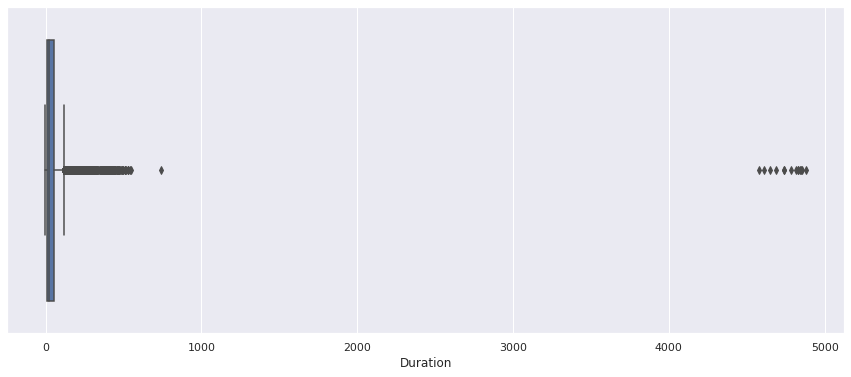

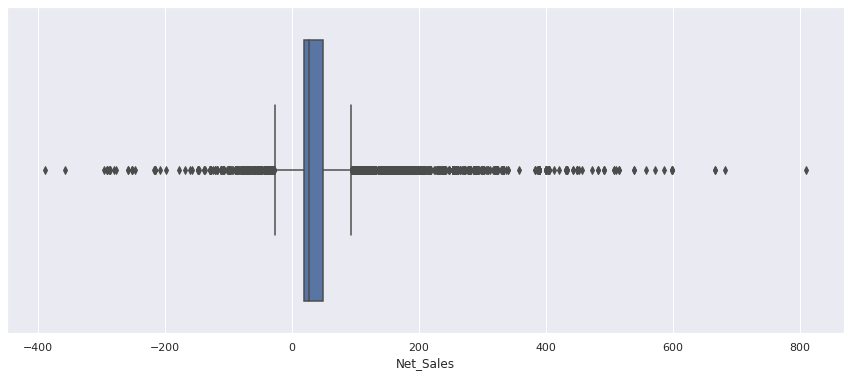

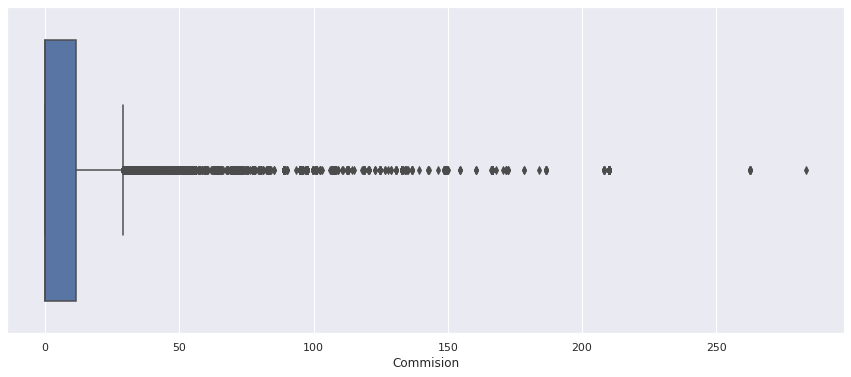

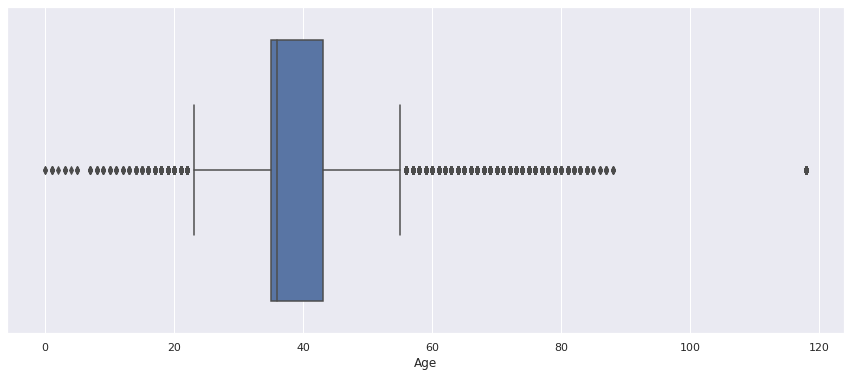

In [49]:
sns.set(rc={'figure.figsize':(15,6)})
for column in numerical:
    plt.figure()
    sns.boxplot(x=df[column])

##Abnormalies detected


*   **Age** equal to **118** is nearly impossible in real life
*   **Net sales** is impossible less than **zero**
*   **Duration** of travel more than **4000** is no longer a travel

Drop the rows contain these abnormalies



In [59]:
list_1=df[(df['Age'] ==118)].index
df.drop(list_1, inplace=True)
list_2=df[(df['Net_Sales'] <=0)].index
df.drop(list_2, inplace=True)
list_3=df[(df['Duration'] >4000)].index
df.drop(list_3, inplace=True)

In [51]:
df.describe()

,Duration,Net_Sales,Commision,Age
count,59797.000000,59797.000000,59797.000000,59797.000000
mean,48.154356,42.970686,9.186296,38.738749
std,74.134226,47.824347,19.459050,10.069305
min,0.000000,0.190000,0.000000,0.000000
25%,9.000000,19.800000,0.000000,35.000000
50%,22.000000,27.000000,0.000000,36.000000
75%,52.000000,49.500000,9.750000,42.000000
max,547.000000,682.000000,262.760000,88.000000


## Label encoding the categorical columns

In [60]:
label_encoder1 = LabelEncoder()
df['Agency']= label_encoder1.fit_transform(df['Agency'])
  
label_encoder2 = LabelEncoder()
df['Type']= label_encoder2.fit_transform(df['Type'])

label_encoder3 = LabelEncoder()
df['Channel']= label_encoder3.fit_transform(df['Channel'])

label_encoder4 = LabelEncoder()
df['Product']= label_encoder4.fit_transform(df['Product'])

label_encoder5 = LabelEncoder()
df['Claim']= label_encoder5.fit_transform(df['Claim'])

label_encoder6 = LabelEncoder()
df['Destination']= label_encoder6.fit_transform(df['Destination'])

## Reindex the column so that 'Claim' (label) is the last column


In [61]:
column_names = ["Agency", "Type", "Channel","Product","Duration","Destination","Net_Sales","Commision","Age","Claim"]
df = df.reindex(columns=column_names)

In [62]:
df

,Agency,Type,Channel,Product,Duration,Destination,Net_Sales,Commision,Age,Claim
21,2,0,1,9,12,116,46.15,11.54,44,0
22,2,0,1,9,7,116,17.55,4.39,25,0
23,2,0,1,9,12,116,94.00,23.50,34,1
24,2,0,1,17,190,116,294.75,73.69,26,0
25,2,0,1,4,364,116,389.00,97.25,30,0
...,...,...,...,...,...,...,...,...,...,...
63321,8,0,1,8,111,62,35.00,12.25,31,0
63322,8,0,1,8,58,25,40.00,14.00,40,0
63323,8,0,1,8,2,77,18.00,6.30,57,0
63324,8,0,1,8,3,142,18.00,6.30,63,0


## Check the correlation table to determine 
*    whether there is high collineartity within the predictive variables
*    whether all of the predictive variable collinear to the target variable

Keep the result, build a baseline model first, do feature selection if the perofrmance is not satisfying

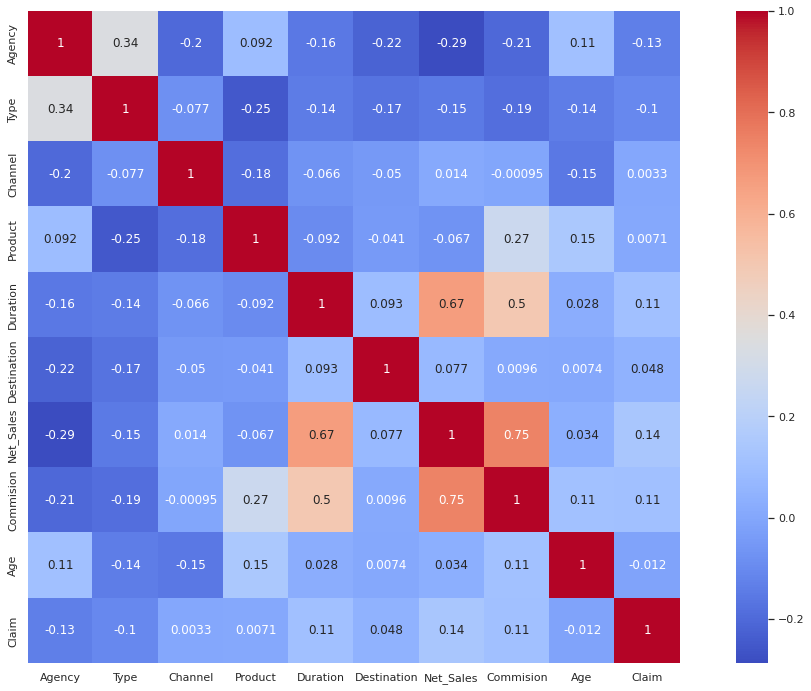

In [64]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), square=True,annot=True,cmap= 'coolwarm')

##Sepearting predictive variable and target variable into X and y respectively.



In [65]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

##Split into train and test set

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)